In [17]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
from tableone import TableOne
wd = '/Volumes/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/BDC/Projects/Viral Shah/Day and Night CGM/'
sns.set_theme(style="whitegrid")
sns.set_palette("coolwarm")

In [18]:
# Import data
df = pd.read_csv(wd+'Data_Clean/analysis_data.csv',usecols=['ID','Age','HbA1c','14 Day TIR','14 Night TIR','14 Day Mean','14 Night Mean'])
df.columns = ['id','age','a1c','day_mbg','day_tir','night_mbg','night_tir']
# Get row with most sensor values for each person in JDRF data
jdrf = pd.read_csv(wd+'Data_Clean/analysis_data_jdrf.csv')
idx = jdrf.groupby('id',sort=False)['sensor_readings'].transform(max) == jdrf['sensor_readings']
jdrf = jdrf[idx]
idx = jdrf["sensor_readings"] >= 2822 # 70% cutoff for 2 weeks of data
jdrf = jdrf[idx]
# Combine
jdrf = jdrf[['id','age','a1c','day_mbg','day_tir','night_mbg','night_tir']]
df = pd.concat([df,jdrf])
df.reset_index(inplace=True,drop=True)

# Data Characteristics
- TIR was calculated using 2 weeks of CGM data prior to an office visit.
- For participants with multiple HbA1c measures, the CGM wear with the largest number of sensor readings was used. This was done to prevent auto-correlation between measures within a subject.
- CGM with < 70% wear were excluded.

In [19]:
# Split into HbA1c groups
df['a1c_group'] = pd.cut(df['a1c'],[0,7,8,9,10,float('inf')],labels = ["<7%","[7.0%, 8.0%)","[8.0%, 9.0%)","[9.0%, 10.0%)",">10%"],right=False)

# Difference between day and night
df['tir_diff'] = df['day_tir'] - df['night_tir']
df['mbg_diff'] = df['day_mbg'] - df['night_mbg']

## Summary Table and Variable Distributions

In [20]:
columns = ['age','a1c','day_mbg','day_tir','night_mbg','night_tir','a1c_group','tir_diff','mbg_diff']
group = ['a1c_group']
TableOne(df, columns, groupby = group)

Grouped by a1c_group                                                                                    
                                   Missing       Overall           <7%  [7.0%, 8.0%)  [8.0%, 9.0%) [9.0%, 10.0%)          >10%
n                                                    339           163           101            39            21            15
age, mean (SD)                           0   38.9 (14.5)   40.3 (13.1)   40.7 (14.7)   34.2 (16.1)   36.1 (17.3)   27.1 (12.5)
a1c, mean (SD)                           0     7.2 (1.4)     6.2 (0.5)     7.4 (0.3)     8.3 (0.3)     9.4 (0.3)    11.4 (1.0)
day_mbg, mean (SD)                       0  166.3 (35.5)  143.4 (23.6)  171.8 (16.7)  191.7 (16.7)  214.1 (30.0)  245.1 (41.8)
day_tir, mean (SD)                       0   56.5 (21.2)   70.2 (16.4)   52.4 (12.9)   37.5 (12.2)   33.1 (15.7)   18.5 (11.3)
night_mbg, mean (SD)                     0  169.1 (40.4)  144.4 (26.0)  177.6 (28.0)  195.6 (28.2)  217.2 (33.7)  244.5 (55.9)
night_tir, mean (SD)                     0   55.1 (23.4)   69.5 (17.8)   49.2 (18.7)   35.2 (16.3)   32.5 (16.8)   21.2 (13.5)
tir_diff, mean (SD)                      0    1.5 (13.6)    0.7 (12.8)    3.2 (14.8)    2.3 (14.4)    0.5 (14.5)   -2.8 (10.7)
mbg_diff, mean (SD)                      0   -2.8 (22.7)   -1.0 (18.8)   -5.9 (24.2)   -3.9 (25.7)   -3.0 (29.8)    0.6 (32.1)

## Mean Day and Night TIR

### By HbA1c Group

#### TIR

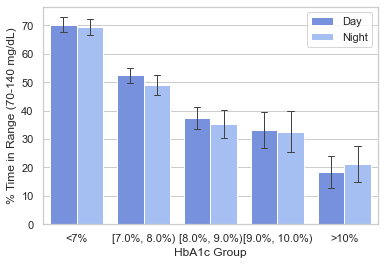

In [21]:
# Wide to long
plot_df = df.melt(id_vars=['a1c','a1c_group'],value_vars=['day_tir','night_tir'], value_name='TIR')
plot_df['variable'].replace({'day_tir':'Day','night_tir':'Night'},inplace=True)
# Plot
plot = sns.barplot(x='a1c_group',y='TIR',hue='variable',data=plot_df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group',ylabel='% Time in Range (70-140 mg/dL)')
plot.legend(title='');

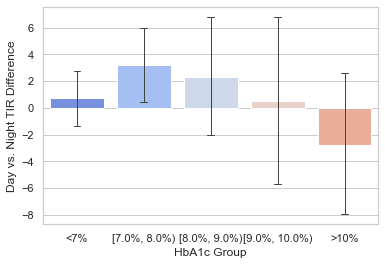

In [22]:
plot = sns.barplot(x='a1c_group',y='tir_diff',data=df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night TIR Difference');

#### Mean Sensor Glucose

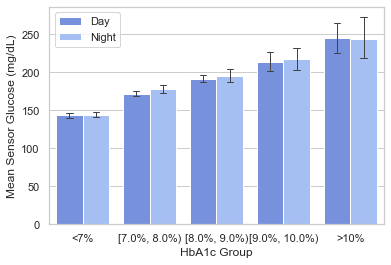

In [23]:
# Wide to long
plot_df = df.melt(id_vars=['a1c','a1c_group'],value_vars=['day_mbg','night_mbg'], value_name='MSG')
plot_df['variable'].replace({'day_mbg':'Day','night_mbg':'Night'},inplace=True)
# Plot
plot = sns.barplot(x='a1c_group',y='MSG',hue='variable',data=plot_df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group',ylabel='Mean Sensor Glucose (mg/dL)')
plot.legend(title='');

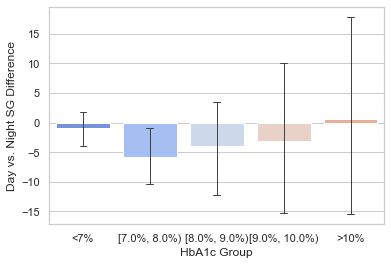

In [24]:
plot = sns.barplot(x='a1c_group',y='mbg_diff',data=df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night SG Difference');

Error bars indicate 95% confidence interval around the mean.

In [25]:
# Tests
lm = smf.ols('day_mbg ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)


,sum_sq,df,F,PR(>F)
a1c_group,254788.700120,4.0,124.352046,7.254594e-65
Residual,171085.697628,334.0,NaN,NaN


In [26]:
lm = smf.ols('night_mbg ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
a1c_group,268143.223069,4.0,78.638612,6.086940e-47
Residual,284719.662904,334.0,NaN,NaN


In [27]:
lm = smf.ols('tir_diff ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
a1c_group,4.0,716.198155,179.049539,0.96463,0.426987
Residual,334.0,61995.305209,185.614686,NaN,NaN


In [28]:
lm = smf.ols('mbg_diff ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
a1c_group,4.0,1708.076158,427.019039,0.823574,0.510844
Residual,334.0,173177.254512,518.494774,NaN,NaN


There were significant differences in day TIR, night TIR, day MSG, and night MSG by HbA1c group (p < 0.001 for all). However, the differences between day and night TIR and day and night MSG were not different between HbA1c groups (p = 0.08 and p = 0.42, respectively).

## Correlations Between All Variables

### Full Cohort

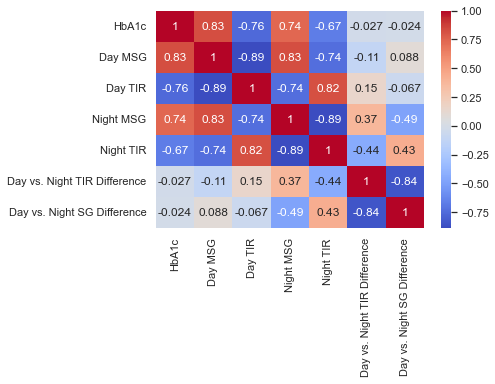

In [29]:
corr_mat = df[['a1c','day_mbg','day_tir','night_mbg','night_tir','a1c_group','tir_diff','mbg_diff']]
corr_mat.columns = ['HbA1c','Day MSG','Day TIR','Night MSG','Night TIR','HbA1c Group','Day vs. Night TIR Difference','Day vs. Night SG Difference']
c_full = corr_mat.corr()
sns.heatmap(c_full,annot=True,cmap="coolwarm");

In [30]:
corr_mat.corr()

,HbA1c,Day MSG,Day TIR,Night MSG,Night TIR,Day vs. Night TIR Difference,Day vs. Night SG Difference
HbA1c,1.000000,0.829728,-0.757742,0.741481,-0.670792,-0.027085,-0.023563
Day MSG,0.829728,1.000000,-0.885491,0.828317,-0.735875,-0.114186,0.087752
Day TIR,-0.757742,-0.885491,1.000000,-0.739517,0.818171,0.151071,-0.066948
Night MSG,0.741481,0.828317,-0.739517,1.000000,-0.887708,0.374236,-0.485411
Night TIR,-0.670792,-0.735875,0.818171,-0.887708,1.000000,-0.444774,0.430012
Day vs. Night TIR Difference,-0.027085,-0.114186,0.151071,0.374236,-0.444774,1.000000,-0.843580
Day vs. Night SG Difference,-0.023563,0.087752,-0.066948,-0.485411,0.430012,-0.843580,1.000000


### By HbA1c Group

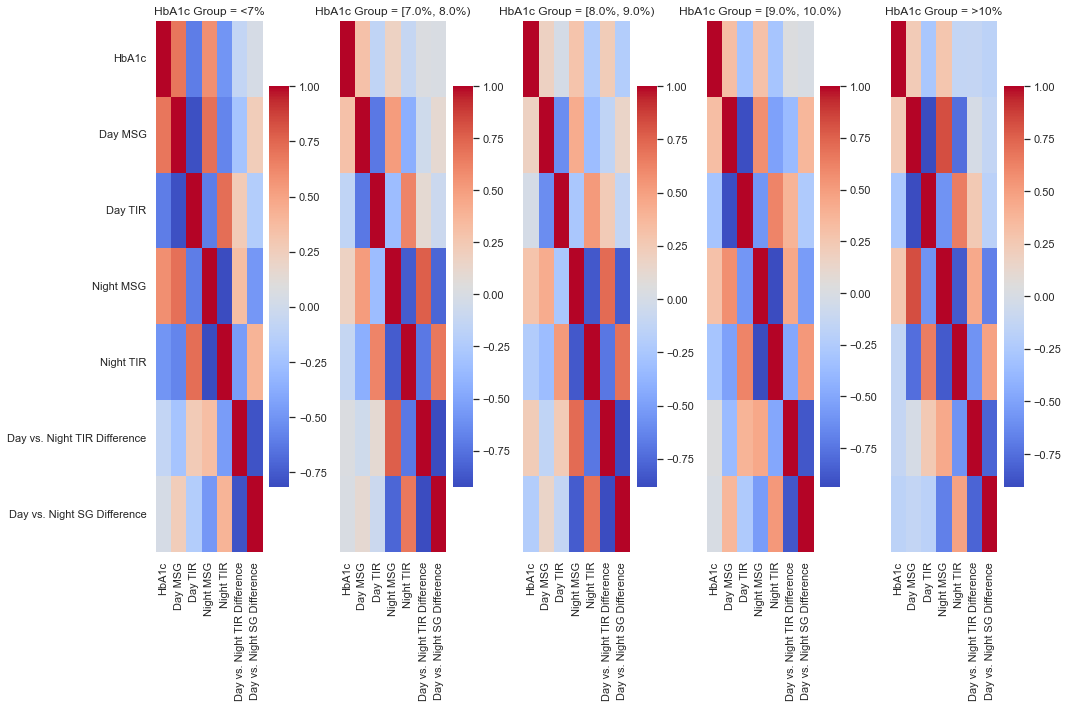

In [31]:
g = sns.FacetGrid(corr_mat, col='HbA1c Group')
g.fig.set_figwidth(15)
g.fig.set_figheight(10)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(),cmap="coolwarm"));

In [32]:
corr_mat.groupby('HbA1c Group').corr()

HbA1c   Day MSG   Day TIR  \
HbA1c Group                                                                
<7%           HbA1c                         1.000000  0.692484 -0.604805   
              Day MSG                       0.692484  1.000000 -0.796362   
              Day TIR                      -0.604805 -0.796362  1.000000   
              Night MSG                     0.595931  0.716402 -0.606146   
              Night TIR                    -0.501123 -0.566011  0.722415   
              Day vs. Night TIR Difference -0.076952 -0.231798  0.274845   
              Day vs. Night SG Difference   0.043214  0.261833 -0.159226   
[7.0%, 8.0%)  HbA1c                         1.000000  0.296681 -0.156177   
              Day MSG                       0.296681  1.000000 -0.720071   
              Day TIR                      -0.156177 -0.720071  1.000000   
              Night MSG                     0.172183  0.508585 -0.354291   
              Night TIR                    -0.124238 -0.449429  0.616350   
              Day vs. Night TIR Difference  0.020916 -0.059574  0.092590   
              Day vs. Night SG Difference   0.005876  0.102731 -0.087751   
[8.0%, 9.0%)  HbA1c                         1.000000  0.194100 -0.000752   
              Day MSG                       0.194100  1.000000 -0.591036   
              Day TIR                      -0.000752 -0.591036  1.000000   
              Night MSG                     0.295576  0.439459 -0.248852   
              Night TIR                    -0.211804 -0.327022  0.524701   
              Day vs. Night TIR Difference  0.240272 -0.128499  0.249945   
              Day vs. Night SG Difference  -0.198470  0.166660 -0.110449   
[9.0%, 10.0%) HbA1c                         1.000000  0.317269 -0.308297   
              Day MSG                       0.317269  1.000000 -0.922571   
              Day TIR                      -0.308297 -0.922571  1.000000   
              Night MSG                     0.291115  0.568707 -0.594268   
              Night TIR                    -0.306323 -0.534406  0.607066   
              Day vs. Night TIR Difference  0.021587 -0.380372  0.379924   
              Day vs. Night SG Difference  -0.010473  0.362297 -0.255383   
>10%          HbA1c                         1.000000  0.236269 -0.265222   
              Day MSG                       0.236269  1.000000 -0.904674   
              Day TIR                      -0.265222 -0.904674  1.000000   
              Night MSG                     0.272287  0.822098 -0.578217   
              Night TIR                    -0.126821 -0.754828  0.642877   
              Day vs. Night TIR Difference -0.121941 -0.008781  0.251654   
              Day vs. Night SG Difference  -0.166083 -0.127450 -0.173039   

                                            Night MSG  Night TIR  \
HbA1c Group                                                        
<7%           HbA1c                          0.595931  -0.501123   
              Day MSG                        0.716402  -0.566011   
              Day TIR                       -0.606146   0.722415   
              Night MSG                      1.000000  -0.813852   
              Night TIR                     -0.813852   1.000000   
              Day vs. Night TIR Difference   0.356188  -0.466279   
              Day vs. Night SG Difference   -0.485771   0.416686   
[7.0%, 8.0%)  HbA1c                          0.172183  -0.124238   
              Day MSG                        0.508585  -0.449429   
              Day TIR                       -0.354291   0.616350   
              Night MSG                      1.000000  -0.847888   
              Night TIR                     -0.847888   1.000000   
              Day vs. Night TIR Difference   0.763183  -0.727022   
              Day vs. Night SG Difference   -0.804209   0.669313   
[8.0%, 9.0%)  HbA1c                          0.295576  -0.211804   
              Day MSG                        0.439459  -0.327022   
          